## SNPKebab is an SVM regression model that predicts the expected allele fraction of a mutation at a given site at a genome. The informative features for the model are the gc content of the region, mappability, proximity to baits, overlap with segmental duplications and germline copy number gains, distribution of germline SNP variant allele fractions closest to the site, and the distance to the nearest germline SNP

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision
from torchvision import transforms
import twobitreader
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVR
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import pickle


In [2]:
#functions used throughout the notebook

## these first two functions are only used if the reference context is a feature in the model ##
# bmap = {"A":0, "C":1, "G":2, "T":3}
# def one_hot(b):
#     t = [0,0,0,0]
#     if b is not "N":
#         i = bmap[b]
#         t[i] = 1
        
#     return t

# def call_stats_encode(read):
    
#     coded_seq=[]
    
#     for char in read:
#         coded_seq.extend(one_hot(char))
        
#     return coded_seq

    #return torch.FloatTensor([one_hot(c) for c in read]).requires_grad_(True)

#translate alphabetical chromosomes to numbers
def chrom2int(x):
    if x == 'X':
        return 23
    elif x == 'Y':
        return 24
    else:
        return int(x)

#get reference context based on start and end position
def get_reference(genome,chrom,start,end):

    contig=genome[str(chrom)]
    return contig[start:end+1]

#extract the reads from a reference genome
def find_reads(chrm,pos,rep_len):

    # initialize 2bitreader genome
    genome = twobitreader.TwoBitFile("hg19.2bit")
    chr=[genome[c] for c in map(str,range(1,23))]
    chr.append(genome['X'])
    chr.append(genome['Y'])

    read=get_reference(genome,chrm,pos-(rep_len//2)-1,pos+(rep_len//2)-1)
    
    return read

#get gc content
def gc_content(read):
    return (read.count('G')+read.count('C'))/len(read)

#identify order of magnitude of a value in log10 space
def magnitude(x):
    try:
        return int(math.log10(x))
    except ValueError:
        return 1

#one-hot encode genomic distances based on the magnitude of the distance in log10 space
def distance_encode(dist):
    dlist=[0,0,0,0,0,0,0,0]    
    i=magnitude(dist)
    
    dlist[i]=1
    
    return dlist

In [1]:
#TRAINING AND K-FOLD VALIDATION SVM BASELINE

#training data name
input_filename="call_stat_training/small_case_shuffled_medians_segdup_CNV_proxy_map_dist_bait_gc.txt"

#test data name
test_filename="test_prepared.txt"

# 10 folds
k=10

#if loss drops below this value, end training
error_tol=1e-4

cs=pd.read_csv(input_filename,sep='\t')

#shuffle training and holdout data
cs=cs.sample(frac=1,random_state=1)
cs.reset_index(inplace=True)

cs_holdout=cs.sample(frac=0.1,random_state=1)

cs_prep=cs.loc[~cs.index.isin(cs_holdout.index),:]
cs_prep.reset_index(inplace=True)
cs_holdout.reset_index(inplace=True)

cs_k_fold=np.array_split(cs_prep,k)
cs_valid=pd.DataFrame()

performance_k=[]
stdev_k=[]
baseline_performance=[]
for fold in range(k):

    criterion = nn.SmoothL1Loss() 
    plt.gcf().clear()

    cs_train=pd.DataFrame()
    
    #iterate through fold
    for number,group in enumerate(cs_k_fold):
        if fold==number:
            cs_valid=group
        else:
            cs_train=cs_train.append(group)
        
    cs_train=cs_train.reset_index(drop=True)
    cs_valid=cs_valid.reset_index(drop=True)
    #feature preparation for training
    X=[]
    y=[]
    with torch.no_grad():
        for idx,row in cs_train.iterrows():
            val=distance_encode(row['distance_prev'])
            val.extend(distance_encode(row['distance_next']))
            val.extend(distance_encode(row['distance_to_bait']))
            val.extend(pd.Series(row[['has_segdup','gain_overlap',
                                            'af_next','af_prev','score','gc_content',
                                     'less_than_0.1','between_0.1_0.2',
                                                      'between_0.2_0.3','between_0.3_0.4',
                                                      'between_0.4_0.5','between_0.5_0.6']],
                                                   dtype=np.float32).values)

            values_X = torch.FloatTensor(val).numpy()
            values_y = torch.FloatTensor(pd.Series(row['tumor_f'],dtype=np.float32).values).numpy()

            X.append(values_X)
            y.append(values_y)

        #training
        clf = SVR(gamma='scale', C=1.0, epsilon=0.01)
        clf.fit(X, y)
        print(clf.score(X,y))

        baseline_loss=[]
        base_loss=0
        for idx,row in cs_valid.iterrows():

            val=distance_encode(row['distance_prev'])
            val.extend(distance_encode(row['distance_next']))
            val.extend(distance_encode(row['distance_to_bait']))
            val.extend(pd.Series(row[['has_segdup','gain_overlap',
                                            'af_next','af_prev','score','gc_content',
                                     'less_than_0.1','between_0.1_0.2',
                                                      'between_0.2_0.3','between_0.3_0.4',
                                                      'between_0.4_0.5','between_0.5_0.6']],
                                                   dtype=np.float32).values)

            val = torch.FloatTensor(val).numpy()
            base_X = clf.predict(val.reshape(1,-1))        

            base_loss+=criterion(torch.from_numpy(base_X),torch.FloatTensor(
                        pd.Series(cs_valid.loc[idx,'tumor_f'],dtype=np.float32).values).double())

            #plot correlation between predictions and targets
            plt.scatter(base_X,cs_valid.loc[idx,'tumor_f'])
            plt.xlabel('predicted_af')
            plt.ylabel('target_af')
            plt.savefig("value_pred_"+str(fold)+".png")

            if idx%4==3:            
                baseline_loss.append(base_loss.item()/4)
                base_loss=0
                

        #plot loss over iterations
        plt.gcf().clear()
        baseline_performance.append(np.mean(baseline_loss))
        plt.scatter(np.arange(0,len(baseline_loss)),baseline_loss,c='r',
                    label='baseline' if i == 0 else "")
        plt.xlabel('batch')
        plt.ylabel('loss') 
        plt.savefig("baseline_loss_"+str(fold)+".png")
        
        print(baseline_performance)
        print(np.mean(baseline_performance))
        print(np.max(baseline_loss))
        plt.gcf().clear()


NameError: name 'pd' is not defined

In [18]:
## Use pre-trained model ##

#SVM application to test data

test_filename="test_prepared.txt"
test=pd.read_csv(test_filename,sep='\t')

plt.gcf().clear()

#load model
with open("call_stat_training/svr_germline.pickle", 'rb') as pickle_file:
    clf=pickle.load(pickle_file)

predictions=[]
for idx,row in test.iterrows():

    #prepare test data for prediction
    val=distance_encode(row['distance_prev'])
    val.extend(distance_encode(row['distance_next']))
    val.extend(distance_encode(row['distance_to_bait_x']))
    val.extend(pd.Series(row[['has_segdup_x','gain_overlap_x',
                                    'af_next','af_prev','score_x','gc_content_x',
                             'less_than_0.1','between_0.1_0.2',
                                              'between_0.2_0.3','between_0.3_0.4',
                                              'between_0.4_0.5','between_0.5_0.6']],
                                           dtype=np.float32).values)

    val = torch.FloatTensor(val).numpy()
    
    #predict
    base_X = clf.predict(val.reshape(1,-1))
    predictions.append(base_X)

test['predicted_germ_af']=predictions

test.to_csv("test_predicted.txt",sep='\t',index=False)

/Users/mleventh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,44,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mleventh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


       Hugo_Symbol  has_segdup_x  gain_overlap_x   af_next   af_prev  \
0              NaN             0               0  0.428571  0.500000   
1              NaN             0               0  0.428571  0.500000   
2              NaN             0               0  0.428571  0.500000   
3              NaN             0               0  0.428571  0.500000   
4              NaN             0               0  0.428571  0.500000   
5              NaN             0               0  0.428571  0.500000   
6              NaN             0               0  0.428571  0.500000   
7              NaN             0               0  0.428571  0.500000   
8              NaN             0               0  0.428571  0.500000   
9              NaN             0               0  0.048544  0.428571   
10             NaN             0               0  0.048544  0.428571   
11             NaN             0               0  0.048544  0.428571   
12             NaN             0               0  0.555556  0.40

<Figure size 432x288 with 0 Axes>

In [5]:
#SVM application to test data where the SVM is being trained in the same step as testing

#training data name
input_filename="call_stat_training/small_case_shuffled_medians_segdup_CNV_proxy_map_dist_bait_gc.txt"

#test data name
test_filename="test_prepared.txt"
test=pd.read_csv(test_filename,sep='\t')

cs=pd.read_csv(input_filename,sep='\t')

#shuffle training data
cs=cs.sample(frac=1,random_state=1)
cs.reset_index(inplace=True)

plt.gcf().clear()

#training data preparation
X=[]
y=[]
with torch.no_grad():
    for idx,row in cs.iterrows():
        val=distance_encode(row['distance_prev'])
        val.extend(distance_encode(row['distance_next']))
        val.extend(distance_encode(row['distance_to_bait']))
        val.extend(pd.Series(row[['has_segdup','gain_overlap',
                                        'af_next','af_prev','score','gc_content',
                                 'less_than_0.1','between_0.1_0.2',
                                                  'between_0.2_0.3','between_0.3_0.4',
                                                  'between_0.4_0.5','between_0.5_0.6']],
                                               dtype=np.float32).values)

        values_X = torch.FloatTensor(val).numpy()
        values_y = torch.FloatTensor(pd.Series(row['tumor_f'],dtype=np.float32).values).numpy()

        X.append(values_X)
        y.append(values_y)

    #training 
    clf = SVR(gamma='scale', C=1.0, epsilon=0.01)
    clf.fit(X, y)
    #print R-squared value between predictions and features
    print(clf.score(X,y))

    predictions=[]
    for idx,row in test.iterrows():
        
        val=distance_encode(row['distance_prev'])
        val.extend(distance_encode(row['distance_next']))
        val.extend(distance_encode(row['distance_to_bait_x']))
        val.extend(pd.Series(row[['has_segdup_x','gain_overlap_x',
                                        'af_next','af_prev','score_x','gc_content_x',
                                 'less_than_0.1','between_0.1_0.2',
                                                  'between_0.2_0.3','between_0.3_0.4',
                                                  'between_0.4_0.5','between_0.5_0.6']],
                                               dtype=np.float32).values)

        val = torch.FloatTensor(val).numpy()
        base_X = clf.predict(val.reshape(1,-1))
        predictions.append(base_X)

test['predicted_germ_af']=predictions

test.to_csv("test_predict.txt",sep='\t',index=False)

/Users/mleventh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9793637914153991


<Figure size 432x288 with 0 Axes>

# Below is the code that features a neural net implementation to solve the problem of identifying germline skew. While I do not use them, I have kept them for posterity

In [4]:
class NNet(nn.Module):
    # use prior architectures. 
    def __init__(self): #self,n_input_features,hidden_size,n_layers
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(37, 72)
        self.dropout = nn.Dropout(0.1) 
        self.fc2 = nn.Linear(72, 72)
        self.fc3 = nn.Linear(72,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x))) 
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x


In [171]:
class csDataset(Dataset):
    """call stat dataset."""

    def __init__(self, df, transform=None):
        """
        Args:
            tsv_file (string): Path to the tsv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cs_frame = df
        self.transform = transform

    def __len__(self):
        return len(self.cs_frame)

    def __getitem__(self, idx):

        items=distance_encode(self.cs_frame.loc[idx,'distance_prev'])
        items.extend(distance_encode(self.cs_frame.loc[idx,'distance_next']))
        items.extend(distance_encode(self.cs_frame.loc[idx,'distance_to_bait']))
        items.extend(pd.Series(self.cs_frame.loc[idx, ['has_segdup','gain_overlap',
                                        'loss_overlap','af_next','af_prev','score','gc_content',
                                                      'less_than_0.1','between_0.1_0.2',
                                                      'between_0.2_0.3','between_0.3_0.4',
                                                      'between_0.4_0.5','between_0.5_0.6']],
                                               dtype=np.float32).values)
        
        features = torch.FloatTensor(items)        
        target = torch.FloatTensor(pd.Series(self.cs_frame.loc[idx,'tumor_f'],dtype=np.float32).values)

        sample = {'target':target,
                  'features': features}

        if self.transform:
            sample = self.transform(sample)

        return sample


0.9962360394613674


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 0, 0.05253944545984268]
[0, 1, 0.07952087372541428]
[0, 2, 0.03024531714618206]
[0, 3, 0.02602461725473404]
[0, 4, 0.07119030505418777]
[0, 5, 0.01598242111504078]
[0, 6, 0.027178972959518433]
[0, 7, 0.012178056873381138]
[0, 8, 0.026766687631607056]
[0, 9, 0.03332822397351265]
[0, 10, 0.05435416102409363]
[0, 11, 0.04255320131778717]
[0, 12, 0.03861096501350403]
[0, 13, 0.024936726316809654]
[0, 14, 0.03151020407676697]
[0, 15, 0.02520853839814663]
[0, 16, 0.05971593037247658]
[0, 17, 0.029427893459796906]
[1, 0, 0.008918842300772667]
[1, 1, 0.06055452302098274]
[1, 2, 0.01734192855656147]
[1, 3, 0.007535894401371479]
[1, 4, 0.05141014978289604]
[1, 5, 0.013816886581480503]
[1, 6, 0.05092138051986694]
[1, 7, 0.0858013704419136]
[1, 8, 0.028165442869067192]
[1, 9, 0.033078551292419434]
[1, 10, 0.03595985099673271]
[1, 11, 0.03890211880207062]
[1, 12, 0.02136315032839775]
[1, 13, 0.06012430787086487]
[1, 14, 0.015540623106062412]
[1, 15, 0.06400749832391739]
[1, 16, 0.01230397168546

/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.03028625374039014
model
[0.03028625374039014]
baseline
[0.0008803070012053868]
0.03028625374039014
0.99589670313492


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 0, 0.03977815806865692]
[0, 1, 0.04040730372071266]
[0, 2, 0.016029877588152885]
[0, 3, 0.027393503114581108]
[0, 4, 0.03362492471933365]
[0, 5, 0.0406283400952816]
[0, 6, 0.043320052325725555]
[0, 7, 0.017339685931801796]
[0, 8, 0.02543572150170803]
[0, 9, 0.042185865342617035]
[0, 10, 0.029421141371130943]
[0, 11, 0.026517342776060104]
[0, 12, 0.010474911890923977]
[0, 13, 0.02550555020570755]
[0, 14, 0.05504125356674194]
[0, 15, 0.0552484430372715]
[0, 16, 0.030462196096777916]
[0, 17, 0.050294727087020874]
[0, 18, 0.001665025483816862]
[1, 0, 0.012930410914123058]
[1, 1, 0.021449191495776176]
[1, 2, 0.03353285789489746]
[1, 3, 0.031470149755477905]
[1, 4, 0.024843156337738037]
[1, 5, 0.03452359884977341]
[1, 6, 0.016718486323952675]
[1, 7, 0.0394064337015152]
[1, 8, 0.007802703883498907]
[1, 9, 0.05670676752924919]
[1, 10, 0.012812605127692223]
[1, 11, 0.047570765018463135]
[1, 12, 0.06745945662260056]
[1, 13, 0.04761631786823273]
[1, 14, 0.04470600187778473]
[1, 15, 0.01429211

/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.026461408007889986
model
[0.03028625374039014, 0.026461408007889986]
baseline
[0.0008803070012053868, 0.00250992725353454]
0.02837383087414006
0.9960541217685248


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 0, 0.028559718281030655]
[0, 1, 0.015949873253703117]
[0, 2, 0.02178327366709709]
[0, 3, 0.020597953349351883]
[0, 4, 0.03355374187231064]
[0, 5, 0.03165321797132492]
[0, 6, 0.018059758469462395]
[0, 7, 0.04777907952666283]
[0, 8, 0.04610659182071686]
[0, 9, 0.025009209290146828]
[0, 10, 0.027414517477154732]
[0, 11, 0.0240896288305521]
[0, 12, 0.03495751693844795]
[0, 13, 0.025386324152350426]
[0, 14, 0.043989915400743484]
[0, 15, 0.0033629294484853745]
[0, 16, 0.016382282599806786]
[0, 17, 0.040536701679229736]
[0, 18, 0.004793083760887384]
[1, 0, 0.038328059017658234]
[1, 1, 0.03962075710296631]
[1, 2, 0.008921469561755657]
[1, 3, 0.008128125220537186]
[1, 4, 0.0031665191054344177]
[1, 5, 0.02218521013855934]
[1, 6, 0.018104489892721176]
[1, 7, 0.06812449544668198]
[1, 8, 0.0662289410829544]
[1, 9, 0.012108087539672852]
[1, 10, 0.028631001710891724]
[1, 11, 0.009214811958372593]
[1, 12, 0.01419838983565569]
[1, 13, 0.008809848688542843]
[1, 14, 0.022766850888729095]
[1, 15, 0.02

/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.03062516078352928
model
[0.03028625374039014, 0.026461408007889986, 0.03062516078352928]
baseline
[0.0008803070012053868, 0.00250992725353454, 0.0027250620177773485]
0.03028625374039014
0.9967675479145257


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 0, 0.05193880945444107]
[0, 1, 0.03533356264233589]
[0, 2, 0.009687484242022038]
[0, 3, 0.010722811333835125]
[0, 4, 0.021927963942289352]
[0, 5, 0.03182363510131836]
[0, 6, 0.012653971090912819]
[0, 7, 0.03554422780871391]
[0, 8, 0.06426835805177689]
[0, 9, 0.030096033588051796]
[0, 10, 0.03193238750100136]
[0, 11, 0.020360324531793594]
[0, 12, 0.027726318687200546]
[0, 13, 0.043195635080337524]
[0, 14, 0.05658188462257385]
[0, 15, 0.05642547830939293]
[0, 16, 0.09280258417129517]
[0, 17, 0.04018586128950119]
[0, 18, 0.008864756673574448]
[1, 0, 0.03785121813416481]
[1, 1, 0.011147281154990196]
[1, 2, 0.013802911154925823]
[1, 3, 0.07092316448688507]
[1, 4, 0.044216338545084]
[1, 5, 0.04640473425388336]
[1, 6, 0.029970472678542137]
[1, 7, 0.02331663854420185]
[1, 8, 0.033808931708335876]
[1, 9, 0.05309271439909935]
[1, 10, 0.035732876509428024]
[1, 11, 0.04773147031664848]
[1, 12, 0.057117901742458344]
[1, 13, 0.03695055469870567]
[1, 14, 0.007464081514626741]
[1, 15, 0.0262357126

/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.020598918199539185
model
[0.03028625374039014, 0.026461408007889986, 0.03062516078352928, 0.020598918199539185]
baseline
[0.0008803070012053868, 0.00250992725353454, 0.0027250620177773485, 0.0012029617530135194]
0.02837383087414006
0.9962631317525249


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 0, 0.05497271195054054]
[0, 1, 0.07816746830940247]
[0, 2, 0.04753706231713295]
[0, 3, 0.013662085868418217]
[0, 4, 0.0474412627518177]
[0, 5, 0.025503478944301605]
[0, 6, 0.03425736352801323]
[0, 7, 0.04814708232879639]
[0, 8, 0.03746848553419113]
[0, 9, 0.05184134468436241]
[0, 10, 0.027785221114754677]
[0, 11, 0.02330332249403]
[0, 12, 0.03590086102485657]
[0, 13, 0.06066909804940224]
[0, 14, 0.007346747908741236]
[0, 15, 0.02769111655652523]
[0, 16, 0.03829755261540413]
[0, 17, 0.005502763204276562]
[0, 18, 0.10333605855703354]
[1, 0, 0.00943271815776825]
[1, 1, 0.04551075026392937]
[1, 2, 0.0010213650530204177]
[1, 3, 0.019132860004901886]
[1, 4, 0.036070141941308975]
[1, 5, 0.012407129630446434]
[1, 6, 0.041816312819719315]
[1, 7, 0.07228979468345642]
[1, 8, 0.06179553270339966]
[1, 9, 0.014055403880774975]
[1, 10, 0.027023036032915115]
[1, 11, 0.05065028369426727]
[1, 12, 0.046139344573020935]
[1, 13, 0.04110933840274811]
[1, 14, 0.006601603701710701]
[1, 15, 0.0601121261715

/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.024733711499720812
model
[0.03028625374039014, 0.026461408007889986, 0.03062516078352928, 0.020598918199539185, 0.024733711499720812]
baseline
[0.0008803070012053868, 0.00250992725353454, 0.0027250620177773485, 0.0012029617530135194, 0.0013490988209214107]
0.026461408007889986
0.9964526999258647


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 0, 0.045218080282211304]
[0, 1, 0.023642882704734802]
[0, 2, 0.04322242736816406]
[0, 3, 0.05261434614658356]
[0, 4, 0.0261392779648304]
[0, 5, 0.022989638149738312]
[0, 6, 0.013367699459195137]
[0, 7, 0.06408318132162094]
[0, 8, 0.06038254126906395]
[0, 9, 0.027998516336083412]
[0, 10, 0.01943640597164631]
[0, 11, 0.018863243982195854]
[0, 12, 0.046042490750551224]
[0, 13, 0.04326329752802849]
[0, 14, 0.046776700764894485]
[0, 15, 0.008807072415947914]
[0, 16, 0.017797576263546944]
[0, 17, 0.05195532739162445]
[0, 18, 0.09830358624458313]
[1, 0, 0.037456266582012177]
[1, 1, 0.021922342479228973]
[1, 2, 0.023579871281981468]
[1, 3, 0.006925961002707481]
[1, 4, 0.0210141371935606]
[1, 5, 0.038441892713308334]
[1, 6, 0.04061480611562729]
[1, 7, 0.060751184821128845]
[1, 8, 0.034500233829021454]
[1, 9, 0.02323499694466591]
[1, 10, 0.06379034370183945]
[1, 11, 0.02752103842794895]
[1, 12, 0.04389016330242157]
[1, 13, 0.01335960440337658]
[1, 14, 0.015139801427721977]
[1, 15, 0.03784898

/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type NNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0.0207356212195009
model
[0.03028625374039014, 0.026461408007889986, 0.03062516078352928, 0.020598918199539185, 0.024733711499720812, 0.0207356212195009]
baseline
[0.0008803070012053868, 0.00250992725353454, 0.0027250620177773485, 0.0012029617530135194, 0.0013490988209214107, 0.006335022655037001]
0.0255975597538054
0.9960662004645322


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 0, 0.026721887290477753]
[0, 1, 0.06851954013109207]
[0, 2, 0.012402198277413845]
[0, 3, 0.03696715459227562]
[0, 4, 0.05007806047797203]
[0, 5, 0.044440239667892456]
[0, 6, 0.007411926053464413]
[0, 7, 0.047338735312223434]
[0, 8, 0.02940528653562069]
[0, 9, 0.026957066729664803]
[0, 10, 0.06179336830973625]
[0, 11, 0.027833444997668266]
[0, 12, 0.0356653556227684]
[0, 13, 0.0531834252178669]


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mleventh/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/mleventh/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/mleventh/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/mleventh/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/mleventh/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/mleventh/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/mleventh/anaconda3/lib/python3.6/multiproces

KeyboardInterrupt: 

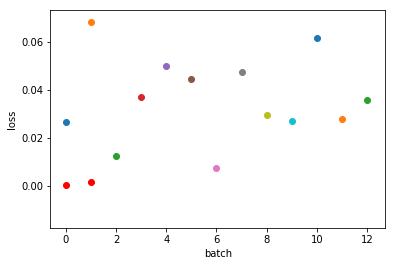

In [176]:
###k-fold val new features###

input_filename="call_stat_training/small_case_shuffled_medians_segdup_CNV_proxy_map_dist_bait_gc.txt"
k=10
error_tol=1e-4

cs=pd.read_csv(input_filename,sep='\t')
cs=cs.sample(frac=1,random_state=1)
cs.reset_index(inplace=True)

cs_holdout=cs.sample(frac=0.1,random_state=1)

cs_prep=cs.loc[~cs.index.isin(cs_holdout.index),:]
cs_prep.reset_index(inplace=True)
cs_holdout.reset_index(inplace=True)

cs_k_fold=np.array_split(cs_prep,k)
cs_valid=pd.DataFrame()

performance_k=[]
stdev_k=[]
baseline_performance=[]

for fold in range(k):
    
    net = NNet()

    criterion = nn.SmoothL1Loss() 
    plt.gcf().clear()
    
    optimizer = optim.Adam(net.parameters(), lr=0.0001) # maybe replace with Adam
    cs_train=pd.DataFrame()

    
    for number,group in enumerate(cs_k_fold):
        if fold==number:
            cs_valid=group
        else:
            cs_train=cs_train.append(group)
        
    cs_train=cs_train.reset_index(drop=True)
    cs_valid=cs_valid.reset_index(drop=True)
    transformed_dataset = csDataset(df=cs_train)

    cs = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
    
    #baseline_testing
    X=[]
    y=[]
    with torch.no_grad():
        for idx,row in cs_train.iterrows():
            val=distance_encode(row['distance_prev'])
            val.extend(distance_encode(row['distance_next']))
            val.extend(distance_encode(row['distance_to_bait']))
            val.extend(pd.Series(row[['has_segdup','gain_overlap',
                                            'loss_overlap','af_next','af_prev','score','gc_content',
                                     'less_than_0.1','between_0.1_0.2',
                                                      'between_0.2_0.3','between_0.3_0.4',
                                                      'between_0.4_0.5','between_0.5_0.6']],
                                                   dtype=np.float32).values)

            values_X = torch.FloatTensor(val).numpy()
            values_y = torch.FloatTensor(pd.Series(row['tumor_f'],dtype=np.float32).values).numpy()

            X.append(values_X)
            y.append(values_y)

        clf = SVR(gamma='scale', C=1.0, epsilon=0.01)
        clf.fit(X, y)
        print(clf.score(X,y))

        baseline_loss=[]
        base_loss=0
        for idx,row in cs_valid.iterrows():

            val=distance_encode(row['distance_prev'])
            val.extend(distance_encode(row['distance_next']))
            val.extend(distance_encode(row['distance_to_bait']))
            val.extend(pd.Series(row[['has_segdup','gain_overlap',
                                            'loss_overlap','af_next','af_prev','score','gc_content',
                                     'less_than_0.1','between_0.1_0.2',
                                                      'between_0.2_0.3','between_0.3_0.4',
                                                      'between_0.4_0.5','between_0.5_0.6']],
                                                   dtype=np.float32).values)

            val = torch.FloatTensor(val).numpy()
            base_X = clf.predict(val.reshape(1,-1))        

            base_loss+=criterion(torch.from_numpy(base_X),torch.FloatTensor(
                        pd.Series(cs_valid.loc[idx,'tumor_f'],dtype=np.float32).values).double())

            if idx%4==3:            
                baseline_loss.append(base_loss.item()/4)
                base_loss=0

        baseline_performance.append(np.mean(baseline_loss))
        plt.scatter(np.arange(0,len(baseline_loss)),baseline_loss,c='r',
                    label='baseline' if i == 0 else "")
        plt.xlabel('batch')
        plt.ylabel('loss') 
        plt.savefig("baseline_loss_"+str(fold)+".png")

    for epoch in range(2):
        running_loss = 0.0
        net.train()

        for i, data in enumerate(cs):
            targets, inputs = data['target'],data['features']

            outputs = net(inputs)

            loss = criterion(outputs,targets)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            print([epoch,i,loss.item()])
            
            plt.scatter(i+(120*epoch),loss.item(),
                label='training' if i == 0 else "")
            plt.xlabel('batch')
            plt.ylabel('loss')
        plt.savefig("loss_"+str(fold)+".png")
        
    torch.save(net, "fold_dev")
            
    #eval_df=pd.DataFrame(columns=["pred","target"])        
    with torch.no_grad():
        
        transformed_dataset = csDataset(df=cs_valid)

        val = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
        net.eval()
        shifts=[]
        baseline_shifts=[]
        plt.gcf().clear()
        for i, data in enumerate(val,0):
            
            targets,inputs=data['target'],data['features']
            
            outputs=net(inputs)

            loss = criterion(outputs,targets)

            shifts.append(loss.item())
            
#             print([outputs,targets])
#             plt.scatter(outputs,targets)
#             plt.xlabel('predicted_af')
#             plt.ylabel('target_af')

            running_loss += loss.item()

        plt.scatter(np.arange(0,len(shifts)),shifts,c='b',
                    label='validation' if i == 0 else "")
        plt.xlabel('batch')
        plt.ylabel('loss') 
        plt.savefig("loss_"+str(fold)+".png")
        plt.gcf().clear()

        performance=np.mean(shifts)
        print(np.mean(shifts))

        performance_k.append(performance)

        print('model')
        print(performance_k)
        print('baseline')
        print(baseline_performance)
        print(np.median(performance_k)
        

with torch.no_grad():

    transformed_dataset = csDataset(df=cs_holdout)

    val = DataLoader(transformed_dataset, batch_size=4,
                    shuffle=True, num_workers=4)
    shifts=[]
    plt.gcf().clear()
    for i, data in enumerate(val,0):

        targets,inputs=data['target'],data['features']

        outputs=net(inputs)
        loss = criterion(outputs,targets)

        shifts.append(loss.item())
            
        running_loss += loss.item()
        
    plt.scatter(np.arange(0,len(shifts)),shifts,c='b',
                label='validation' if i == 0 else "")
    plt.xlabel('batch')
    plt.ylabel('loss') 
    plt.savefig("loss_holdout_"+str(fold)+".png")
    plt.gcf().clear()



In [177]:
# recapitulate runs from a specific fold
net=torch.load("fold_dev")

input_filename="call_stat_training/small_case_shuffled_medians_segdup_CNV_proxy_map_dist_bait_gc.txt"
test_filename="test_prepared.txt"
k=10
error_tol=1e-4

cs=pd.read_csv(input_filename,sep='\t')
cs=cs.sample(frac=1,random_state=1)
#cs=cs.dropna(subset=["context"])
cs.reset_index(inplace=True)

cs_holdout=cs.sample(frac=0.1,random_state=1)

cs_prep=cs.loc[~cs.index.isin(cs_holdout.index),:]
cs_prep.reset_index(inplace=True)
cs_holdout.reset_index(inplace=True)

with torch.no_grad():

    transformed_dataset = csDataset(df=cs_holdout)

    val = DataLoader(transformed_dataset, batch_size=4,
                    shuffle=True, num_workers=4)
    shifts=[]
    plt.gcf().clear()
    for i, data in enumerate(val,0):

        targets,inputs=data['target'],data['features']

        outputs=net(inputs)
        loss = criterion(outputs,targets)

        shifts.append(loss.item())
            
        running_loss += loss.item()
        
    plt.scatter(np.arange(0,len(shifts)),shifts,c='b',
                label='validation' if i == 0 else "")
    plt.xlabel('batch')
    plt.ylabel('loss') 
    plt.savefig("loss_holdout_"+str(fold)+".png")


<Figure size 432x288 with 0 Axes>

# Everything past this point are not things I use, but were previous versions that are useful for posterity and nothing else

/Users/mleventh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7171395887703373
[0.0035008269141375134]
0.0035008269141375134
0.013061327481129797


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7148430459310007
[0.0035008269141375134, 0.003335426583574657]
0.0034181267488560853
0.012965677854359424


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7143762413214527
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517]
0.0033776255148175623
0.0165116954941861


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7162969528696038
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517, 0.003282439402885838]
0.003353828986834631
0.015038823403115471


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7178233685725579
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517, 0.003282439402885838, 0.003518459981458679]
0.003386755185759441
0.015248833261790912


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7183749543070199
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517, 0.003282439402885838, 0.003518459981458679, 0.0033699603689244543]
0.0033839560496202767
0.021485050774715454


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7153302639009829
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517, 0.003282439402885838, 0.003518459981458679, 0.0033699603689244543, 0.0034478814323836804]
0.0033930882471579055
0.01893579086942874


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7142792790851415
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517, 0.003282439402885838, 0.003518459981458679, 0.0033699603689244543, 0.0034478814323836804, 0.0032535146738398085]
0.0033756415504931437
0.015328138738527064


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7163614012887515
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517, 0.003282439402885838, 0.003518459981458679, 0.0033699603689244543, 0.0034478814323836804, 0.0032535146738398085, 0.003300996579600471]
0.0033673476648384023
0.020250092955516497


/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7170729336911758
[0.0035008269141375134, 0.003335426583574657, 0.003296623046740517, 0.003282439402885838, 0.003518459981458679, 0.0033699603689244543, 0.0034478814323836804, 0.0032535146738398085, 0.003300996579600471, 0.0033862561569590393]
0.0033692385140504664
0.01666654453388745


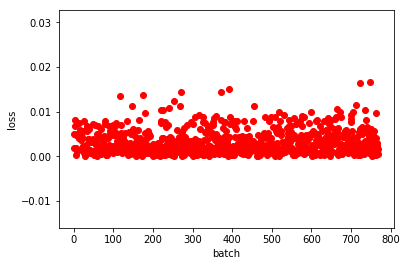

In [7]:
## Random forest baseline test


#baseline only
input_filename="call_stat_training/small_case_shuffled_medians_segdup_CNV_proxy_map_dist_bait_gc.txt"
test_filename="test_prepared.txt"
k=10
error_tol=1e-4

cs=pd.read_csv(input_filename,sep='\t')
cs=cs.sample(frac=1,random_state=1)
#cs=cs.dropna(subset=["context"])
cs.reset_index(inplace=True)

cs_holdout=cs.sample(frac=0.1,random_state=1)

cs_prep=cs.loc[~cs.index.isin(cs_holdout.index),:]
cs_prep.reset_index(inplace=True)
cs_holdout.reset_index(inplace=True)

cs_k_fold=np.array_split(cs_prep,k)
cs_valid=pd.DataFrame()

performance_k=[]
stdev_k=[]
baseline_performance=[]

#baseline=LinearRegressionModel(31,1)
for fold in range(k):
    
    net = NNet()

    criterion = nn.SmoothL1Loss() 
    # probably choose something I would recommend like Binomial or Beta log like
    # can think about KL divergence between observed distribution and predicted i.e. predict parameters of the distribution
    # would need coverage to be an input.
    # probably simplest is just L1 loss to start
    plt.gcf().clear()
    
    optimizer = optim.Adam(net.parameters(), lr=0.0001) # maybe replace with Adam
    cs_train=pd.DataFrame()
    
#     lambda1 = lambda epoch: 0.95 ** (epoch // 30) 
#     scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    
    # use Pytorch dataset and dataloader 
    # construct a sample by features matrix and then feed that to a data loader
    
    for number,group in enumerate(cs_k_fold):
        if fold==number:
            cs_valid=group
        else:
            cs_train=cs_train.append(group)
        
    cs_train=cs_train.reset_index(drop=True)
    cs_valid=cs_valid.reset_index(drop=True)
    #baseline_testing
    X=[]
    y=[]
    with torch.no_grad():
        for idx,row in cs_train.iterrows():
            val=distance_encode(row['distance_prev'])
            val.extend(distance_encode(row['distance_next']))
            val.extend(distance_encode(row['distance_to_bait']))
            val.extend(pd.Series(row[['hwe_fail','has_segdup','gain_overlap',
                                            'loss_overlap','af_next','af_prev','score','gc_content',
                                     'less_than_0.1','between_0.1_0.2',
                                                      'between_0.2_0.3','between_0.3_0.4',
                                                      'between_0.4_0.5','between_0.5_0.6']],
                                                   dtype=np.float32).values)

            values_X = torch.FloatTensor(val).numpy()
            values_y = torch.FloatTensor(pd.Series(row['tumor_f'],dtype=np.float32).values).numpy()

            X.append(values_X)
            y.append(values_y)

        clf = RandomForestRegressor(max_depth=2, random_state=0,
                           n_estimators=100)
        clf.fit(X, y)
        print(clf.score(X,y))

        baseline_loss=[]
        base_loss=0
        for idx,row in cs_valid.iterrows():

            val=distance_encode(row['distance_prev'])
            val.extend(distance_encode(row['distance_next']))
            val.extend(distance_encode(row['distance_to_bait']))
            val.extend(pd.Series(row[['hwe_fail','has_segdup','gain_overlap',
                                            'loss_overlap','af_next','af_prev','score','gc_content',
                                     'less_than_0.1','between_0.1_0.2',
                                                      'between_0.2_0.3','between_0.3_0.4',
                                                      'between_0.4_0.5','between_0.5_0.6']],
                                                   dtype=np.float32).values)

            val = torch.FloatTensor(val).numpy()
            #valid_X.append(val)
            base_X = clf.predict(val.reshape(1,-1))
            weights = clf.decision_path(val.reshape(1,-1))

            base_loss+=criterion(torch.from_numpy(base_X),torch.FloatTensor(
                        pd.Series(cs_valid.loc[idx,'tumor_f'],dtype=np.float32).values).double())

            if idx%4==3:            
                baseline_loss.append(base_loss.item()/4)
                base_loss=0

        baseline_performance.append(np.mean(baseline_loss))
        plt.scatter(np.arange(0,len(baseline_loss)),baseline_loss,c='r',
                    label='baseline')
        plt.xlabel('batch')
        plt.ylabel('loss') 
        plt.savefig("call_stat_training/validation_plots/rf_baseline_loss_"+str(fold)+".png")
        
        print(baseline_performance)
        print(np.mean(baseline_performance))
        print(np.max(baseline_loss))



In [375]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3)
        self.fc1 = nn.Linear(22*64, 1000)
        self.dropout = nn.Dropout(0.1) 
        self.fc2 = nn.Linear(1000, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.sigmoid(self.fc2(x))
        #x.requires_grad_(True)
        return x


In [23]:
#import random
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

def rmse(predictions,target_data):
    return np.sqrt(((predictions - target_data) ** 2).mean())

bmap = {"A":0, "C":1, "G":2, "T":3}
def one_hot(b):
    t = [0,0,0,0]
    if b is not "N":
        i = bmap[b]
        t[i] = 1
        
    return t

def one_hot_binary(val):
    tensor = [[0,0,0,0]]
    
    if val==1:
        tensor[0][1]=1
    else:
        tensor[0][0]=1
        
    return torch.FloatTensor([tensor]).requires_grad_(True)
    

In [158]:
class csDataset(Dataset):
    """call stat dataset."""

    def __init__(self, df, transform=None):
        """
        Args:
            tsv_file (string): Path to the tsv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cs_frame = df
        self.transform = transform

    def __len__(self):
        return len(self.cs_frame)

    def __getitem__(self, idx):

        items=distance_encode(self.cs_frame.loc[idx,'distance_prev'])
        items.extend(distance_encode(self.cs_frame.loc[idx,'distance_next']))
        items.extend(distance_encode(self.cs_frame.loc[idx,'distance_to_bait']))
        items.extend(pd.Series(self.cs_frame.loc[idx, ['has_segdup','gain_overlap',
                                        'loss_overlap','af_next','af_prev','score','gc_content','t_ref_count']],
                                               dtype=np.float32).values)
        
        features = torch.FloatTensor(items)        
        target = torch.FloatTensor(stats.beta.pdf(np.arange(0,1.01,0.01),self.cs_frame.loc['t_alt_count']+1,
                                                  self.cs_Frame['t_ref_count']+1))
        #target = target.astype('float')
        #features = features.astype('float')
        sample = {'target':target,
                  'features': features}

        if self.transform:
            sample = self.transform(sample)

        return sample

# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""

#     def __call__(self, sample):
#         features = sample['features']
#         target = sample['target']
#         return {'target': torch.from_numpy(target),'features': torch.from_numpy(features)}

0.9068990300540847
[tensor([0.0928], dtype=torch.float64), tensor([0.0725], dtype=torch.float64)]
[tensor([0.1501], dtype=torch.float64), tensor([0.0541], dtype=torch.float64)]
[tensor([0.5006], dtype=torch.float64), tensor([0.2637], dtype=torch.float64)]
[tensor([0.2802], dtype=torch.float64), tensor([0.2926], dtype=torch.float64)]
[tensor([0.3044], dtype=torch.float64), tensor([0.0597], dtype=torch.float64)]
[tensor([0.1435], dtype=torch.float64), tensor([0.0525], dtype=torch.float64)]
[tensor([0.3831], dtype=torch.float64), tensor([0.4788], dtype=torch.float64)]
[tensor([0.4408], dtype=torch.float64), tensor([0.5155], dtype=torch.float64)]
[tensor([0.4265], dtype=torch.float64), tensor([0.5472], dtype=torch.float64)]


/Users/mleventh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.

KeyError: 'Traceback (most recent call last):\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1790, in _validate_key\n    error()\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1785, in error\n    axis=self.obj._get_axis_name(axis)))\nKeyError: \'the label [t_alt_count] is not in the [index]\'\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "<ipython-input-158-c759b021a57b>", line 27, in __getitem__\n    target = torch.FloatTensor(stats.beta.pdf(np.arange(0,1.01,0.01),self.cs_frame.loc[\'t_alt_count\']+1,\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1478, in __getitem__\n    return self._getitem_axis(maybe_callable, axis=axis)\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1911, in _getitem_axis\n    self._validate_key(key, axis)\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1798, in _validate_key\n    error()\n  File "/Users/mleventh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1785, in error\n    axis=self.obj._get_axis_name(axis)))\nKeyError: \'the label [t_alt_count] is not in the [index]\'\n'

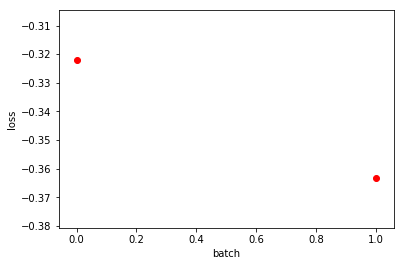

In [162]:
###k-fold val new features, attempt to implement KL divergence###

input_filename="call_stat_training/small_case_shuffled_medians_segdup_CNV_proxy_map_dist_bait_gc.txt"
test_filename="test_prepared.txt"
k=10
error_tol=1e-4

cs=pd.read_csv(input_filename,sep='\t')
cs=cs.sample(frac=1,random_state=1)
#cs=cs.dropna(subset=["context"])
cs.reset_index(inplace=True)

cs_holdout=cs.sample(frac=0.1,random_state=1)

cs_prep=cs.loc[~cs.index.isin(cs_holdout.index),:]
cs_prep.reset_index(inplace=True)
cs_holdout.reset_index(inplace=True)

cs_k_fold=np.array_split(cs_prep,k)
cs_valid=pd.DataFrame()

performance_k=[]
stdev_k=[]
baseline_performance=[]

#baseline=LinearRegressionModel(31,1)
for fold in range(k):
    
    net = NNet()

    criterion = nn.KLDivLoss() 
    plt.gcf().clear()
    
    optimizer = optim.Adam(net.parameters(), lr=0.0001) # maybe replace with Adam
    cs_train=pd.DataFrame()
    
#     lambda1 = lambda epoch: 0.95 ** (epoch // 30) 
#     scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    
    # use Pytorch dataset and dataloader 
    # construct a sample by features matrix and then feed that to a data loader
    
    for number,group in enumerate(cs_k_fold):
        if fold==number:
            cs_valid=group
        else:
            cs_train=cs_train.append(group)
        
    cs_train=cs_train.reset_index(drop=True)
    cs_valid=cs_valid.reset_index(drop=True)
    transformed_dataset = csDataset(df=cs_train)

    cs = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
    
    #baseline_testing
    X=[]
    y=[]
    
    for idx,row in cs_train.iterrows():
        val=distance_encode(row['distance_prev'])
        val.extend(distance_encode(row['distance_next']))
        val.extend(distance_encode(row['distance_to_bait']))
        val.extend(pd.Series(row[['has_segdup','gain_overlap',
                                        'loss_overlap','af_next','af_prev','score','gc_content']],
                                               dtype=np.float32).values)
        
        values_X = torch.FloatTensor(val).numpy()
        values_y = torch.FloatTensor(pd.Series(row['tumor_f'],dtype=np.float32).values).numpy()
        
        X.append(values_X)
        y.append(values_y)

    clf = SVR(gamma='scale', C=1.0, epsilon=0.01)
    clf.fit(X, y)
    print(clf.score(X,y))
    
    baseline_loss=[]
    base_loss=0
    for idx,row in cs_valid.iterrows():
        
        val=distance_encode(row['distance_prev'])
        val.extend(distance_encode(row['distance_next']))
        val.extend(distance_encode(row['distance_to_bait']))
        val.extend(pd.Series(row[['has_segdup','gain_overlap',
                                        'loss_overlap','af_next','af_prev','score','gc_content']],
                                               dtype=np.float32).values)
        
        val = torch.FloatTensor(val).numpy()
        base_X = clf.predict(val.reshape(1,-1))
        
        print([torch.from_numpy(base_X),torch.FloatTensor(
                    pd.Series(cs_valid.loc[idx,'tumor_f'],dtype=np.float32).values).double()])
    
        base_loss+=criterion(torch.from_numpy(base_X),torch.FloatTensor(
                    pd.Series(cs_valid.loc[idx,'tumor_f'],dtype=np.float32).values).double())
        
        if idx%4==3:            
            baseline_loss.append(base_loss.item()/4)
            base_loss=0

    baseline_performance.append(np.mean(baseline_loss))

    plt.scatter(np.arange(0,len(baseline_loss)),baseline_loss,c='r',
                label='baseline' if i == 0 else "")
    plt.xlabel('batch')
    plt.ylabel('loss') 
    plt.savefig("call_stat_training/validation_plots/baseline_loss_"+str(fold)+".png")
        
    for epoch in range(2):
        running_loss = 0.0
        net.train()

        for i, data in enumerate(cs):
            targets, inputs = data['target'],data['features']

            outputs = net(inputs)

            loss = criterion(stats.beta.pdf(np.arange(0,1.01,0.01),outputs+1,inputs.t_ref_count),targets)
            # loss = criterion(outputs,label)

            loss.backward()

            optimizer.step()

            #print([outputs,loss,cs_train.loc[idx,'tumor_f']])
            # print statistics
            running_loss += loss.item()
            #print([epoch,i,loss.item(),outputs])
            print([epoch,i,loss.item()])
            
            plt.scatter(i+(120*epoch),loss.item(),
                label='training' if i == 0 else "")
            plt.xlabel('batch')
            plt.ylabel('loss')
        #plt.savefig("call_stat_training/training_plots/loss_"+str(fold)+".png")
            
    #eval_df=pd.DataFrame(columns=["pred","target"])        
    with torch.no_grad():
        
        transformed_dataset = csDataset(df=cs_valid)

        val = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
        net.eval()
        shifts=[]
        baseline_shifts=[]
        plt.gcf().clear()
        for i, data in enumerate(val,0):
            
            targets,inputs=data['target'],data['features']
            
            outputs=net(inputs)

            loss = criterion(outputs,targets)

            shifts.append(loss.item())
            
#             plt.scatter(outputs,targets)
#             plt.xlabel('predicted_af')
#             plt.ylabel('target_af')

            running_loss += loss.item()

        plt.scatter(np.arange(0,len(shifts)),shifts,c='b',
                    label='validation' if i == 0 else "")
        plt.xlabel('batch')
        plt.ylabel('loss') 
        plt.savefig("loss_"+str(fold)+".png")
        plt.gcf().clear()



        performance=np.mean(shifts)
        print(np.mean(shifts))

        performance_k.append(performance)

        print(performance_k)
        print(baseline_performance)

        

with torch.no_grad():

    transformed_dataset = csDataset(df=cs_holdout)

    val = DataLoader(transformed_dataset, batch_size=4,
                    shuffle=True, num_workers=4)
    shifts=[]
    plt.gcf().clear()
    for i, data in enumerate(val,0):

        targets,inputs=data['target'],data['features']

        outputs=net(inputs)
        loss = criterion(outputs,targets)

        shifts.append(loss.item())
            
        running_loss += loss.item()
        
    plt.scatter(np.arange(0,len(shifts)),shifts,c='b',
                label='validation' if i == 0 else "")
    plt.xlabel('batch')
    plt.ylabel('loss') 
    plt.savefig("loss_holdout_"+str(fold)+".png")
    plt.gcf().clear()

        